In [1]:
#!pip install pyarrow

In [1]:
import pandas as pd
import pyarrow
from pandas import read_parquet

## 1. tbl_merchants
**Columns**
- merchant_abn
- name
- tags
- revenue_levels
- take_rate

In [2]:
tbl_merchants = pd.read_parquet('../data/tables/tbl_merchants.parquet')

In [4]:
tbl_merchants

,name,tags
merchant_abn,,
10023283211,Felis Limited,"((furniture, home furnishings and equipment sh..."
10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a..."
10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]..."
10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]..."
10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a..."
...,...,...
99938978285,Elit Dictum Eu Ltd,"[(opticians, optical goods, and eyeglasses), (..."
99974311662,Mollis LLP,"((books, periodicals, and newspapers), (b), (t..."
99976658299,Sociosqu Corp.,"((shoe shops), (a), (take rate: 6.57))"


In [3]:
tbl_merchants.reset_index().tags[0]

'((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))'

In [4]:
# ETL
# index
tbl_merchants_new = tbl_merchants.reset_index()
# tags
tags_clean = tbl_merchants_new['tags'].str[2:-1].str.replace(')',']').str.replace('(','[').str.replace(']','')
tags_split = tags_clean.str.split('[',expand=True)

tags_final = pd.DataFrame().assign(
    tags = tags_split[0].str.strip().str[:-1],  # delete comma
    revenue_levels = tags_split[1].str.strip().str[:-1],  # delete space and comma
    take_rate = tags_split[2].str.split(':',expand=True)[1].astype(float)
)

# add to dataframe
tbl_merchants_cleaned = tbl_merchants_new.assign(
    tags = tags_final['tags'],  
    revenue_levels = tags_final['revenue_levels'],  
    take_rate = tags_final['take_rate']
)

/home/ydde1/miniconda3/envs/ads/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


In [7]:
tbl_merchants_cleaned

,merchant_abn,name,tags,revenue_levels,take_rate
0,10023283211,Felis Limited,"furniture, home furnishings and equipment shop...",e,0.18
1,10142254217,Arcu Ac Orci Corporation,"cable, satellite, and otHer pay television and...",b,4.22
2,10165489824,Nunc Sed Company,"jewelry, watch, clock, and silverware shops",b,4.40
3,10187291046,Ultricies Dignissim Lacus Foundation,"wAtch, clock, and jewelry repair shops",b,3.29
4,10192359162,Enim Condimentum PC,"music shops - musical instruments, pianos, and...",a,6.33
...,...,...,...,...,...
4021,99938978285,Elit Dictum Eu Ltd,"opticians, optical goods, and eyeglasses",b,4.50
4022,99974311662,Mollis LLP,"books, periodicals, and newspapers",b,3.17
4023,99976658299,Sociosqu Corp.,shoe shops,a,6.57
4024,99987905597,Commodo Hendrerit LLC,motor vehicle Supplies and new parts,a,6.82


## 2. transaction
**Columns**
- user_id
- merchant_abn
- dollar_value
- order_id
- date

In [5]:
from datetime import datetime 
import datetime as dt
data_started = datetime.strptime('2021-02-28', '%Y-%m-%d') # start date of data
data_ended = datetime.strptime('2021-08-27', '%Y-%m-%d') # end date of data

transaction = pd.DataFrame() # store the data
date_i = datetime.strptime('2021-02-28', '%Y-%m-%d')

while date_i <= data_ended:
    data = pd.read_parquet('../data/tables/transactions_20210228_20210827_snapshot/order_datetime={}'.format(
        date_i.strftime("%Y-%m-%d")))  ## collect the daily transaction data
    
    data['date'] = date_i
    
    transaction = pd.concat([transaction,data],axis = 0)
    if date_i.day == 1:
        print(date_i.strftime("%Y-%m-%d"),'done!')
    date_i += dt.timedelta(days=1)


2021-03-01 done!
2021-04-01 done!
2021-05-01 done!
2021-06-01 done!
2021-07-01 done!
2021-08-01 done!


In [9]:
transaction

,user_id,merchant_abn,dollar_value,order_id,date
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28
...,...,...,...,...,...
23197,18470,29323795999,8.346682,f35299fa-c9f4-408e-bb86-b9d5fff65a9a,2021-08-27
23198,18471,21359184622,97.760164,8ed0f865-9f70-4e20-8266-81904c95de89,2021-08-27
23199,18472,21807339153,54.310599,3251ce95-a850-4fbc-98d0-32bce1651d40,2021-08-27
23200,18475,41944909975,103.804012,bd52416a-a7f1-4293-ae96-cc4a8392e414,2021-08-27


## 3. tbl_consumer
**Columns**
- name
- address
- state
- postcode
- gender
- consumer_id

In [6]:
tbl_consumer = pd.read_csv('../data/tables/tbl_consumer.csv',sep='|')

In [11]:
tbl_consumer

,name,address,state,postcode,gender,consumer_id
0,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503
1,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208
2,Jill Jones MD,40693 Henry Greens,NT,862,Female,1194530
3,Lindsay Jimenez,00653 Davenport Crossroad,NSW,2780,Female,154128
4,Rebecca Blanchard,9271 Michael Manors Suite 651,WA,6355,Female,712975
...,...,...,...,...,...,...
499994,Jessica Avila,508 Miranda Overpass Apt. 218,QLD,4400,Female,1385608
499995,Steven Thornton,7913 Schwartz Mission Suite 483,VIC,3097,Undisclosed,1466964
499996,Christy Smith,5681 Zachary Mountain Apt. 060,NSW,2756,Undisclosed,1253484
499997,Donna Sutton,54140 Jacob Point,VIC,3989,Female,175005


In [7]:
consumer_user_details = pd.read_parquet('../data/tables/consumer_user_details.parquet')

In [13]:
consumer_user_details

,user_id,consumer_id
0,1,1195503
1,2,179208
2,3,1194530
3,4,154128
4,5,712975
...,...,...
499994,499995,1385608
499995,499996,1466964
499996,499997,1253484
499997,499998,175005


## 4. new_transaction
**Columns**
- user_id
- merchant_abn
- dollar_value
- order_id
- date

In [8]:
from datetime import datetime 
import datetime as dt
data_started = datetime.strptime('2021-08-28', '%Y-%m-%d') # start date of data
data_ended = datetime.strptime('2022-02-27', '%Y-%m-%d') # end date of data

transaction_new = pd.DataFrame() # store the data
date_i = datetime.strptime('2021-08-28', '%Y-%m-%d')

while date_i <= data_ended:
    data = pd.read_parquet('../data/tables/transactions_20210828_20220227_snapshot/order_datetime={}'.format(
        date_i.strftime("%Y-%m-%d")))  ## collect the daily transaction data
    
    data['date'] = date_i
    
    transaction_new = pd.concat([transaction_new,data],axis = 0)
    if date_i.day == 1:
        print(date_i.strftime("%Y-%m-%d"),'done!')
    date_i += dt.timedelta(days=1)


2021-09-01 done!
2021-10-01 done!
2021-11-01 done!
2021-12-01 done!
2022-01-01 done!
2022-02-01 done!


In [15]:
transaction_new

,user_id,merchant_abn,dollar_value,order_id,date
0,1,45629217853,43.738115,809b9b93-0a7d-4627-abd8-b6899d13f169,2021-08-28
1,14936,24852446429,9.788472,5a04b94c-c553-47c6-b99b-a9697b977984,2021-08-28
2,3,32656335530,100.160247,8776872a-a340-46ff-84c8-a024453ff8c3,2021-08-28
3,14936,72472909171,28.540345,e997036a-1418-44c6-8629-6691a2975297,2021-08-28
4,4,86223953880,313.021668,6161bda6-030c-42c0-8bd6-9067f18d4223,2021-08-28
...,...,...,...,...,...
20773,14931,94455880010,93.759048,29584323-55f2-4e3c-82b4-6c2f4a8d729e,2022-02-27
20774,14931,35755909141,124.307113,300b907e-f902-4f48-a809-7662cb118885,2022-02-27
20775,14931,79417999332,131.169882,1c44d278-5346-4311-b78c-94b3dc5b6e2c,2022-02-27
20776,14932,46804135891,37.889414,3abc2a93-8be3-461b-9754-40152b0451bf,2022-02-27


In [9]:
## Description
transaction_new.groupby('user_id').count().sort_values(by = 'order_id',ascending= False) ## 2408 users

,merchant_abn,dollar_value,order_id,date
user_id,,,,
14596,231,231,231,231
22883,229,229,229,229
8302,228,228,228,228
5793,228,228,228,228
19933,227,227,227,227
...,...,...,...,...
20831,148,148,148,148
1212,147,147,147,147
7190,147,147,147,147


In [17]:
transaction_new.isnull().sum()

user_id         0
merchant_abn    0
dollar_value    0
order_id        0
date            0
dtype: int64

## Merge
- **primary key** & *foreign key*
- tbl_merchants_cleaned：***merchant_abn***｜	name	｜tags｜	revenue_levels	take_rate
- transaction_new：*user_id* ｜	*merchant_abn*	｜dollar_value｜	**order_id**	｜date
- tbl_consumer：name	｜address	｜state	｜postcode｜	gender｜	***consumer_id***
- consumer_user_details：***user_id***	｜***consumer_id***

- 数据量从 **用户有「499,999」，到用户共产生订单「4,508,106」**

In [10]:
merge_1 = pd.merge(tbl_consumer,consumer_user_details,on='consumer_id',how = 'left')
merge_1

,name,address,state,postcode,gender,consumer_id,user_id
0,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,1
1,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208,2
2,Jill Jones MD,40693 Henry Greens,NT,862,Female,1194530,3
3,Lindsay Jimenez,00653 Davenport Crossroad,NSW,2780,Female,154128,4
4,Rebecca Blanchard,9271 Michael Manors Suite 651,WA,6355,Female,712975,5
...,...,...,...,...,...,...,...
499994,Jessica Avila,508 Miranda Overpass Apt. 218,QLD,4400,Female,1385608,499995
499995,Steven Thornton,7913 Schwartz Mission Suite 483,VIC,3097,Undisclosed,1466964,499996
499996,Christy Smith,5681 Zachary Mountain Apt. 060,NSW,2756,Undisclosed,1253484,499997
499997,Donna Sutton,54140 Jacob Point,VIC,3989,Female,175005,499998


In [11]:
merge_2 = pd.merge(transaction, merge_1,on='user_id',how = 'left')
merge_2

,user_id,merchant_abn,dollar_value,order_id,date,name,address,state,postcode,gender,consumer_id
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28,Samuel Haynes,9969 Catherine View Apt. 601,VIC,3073,Male,1212819
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28,Aaron Sawyer,362 Dixon Islands,WA,6646,Male,1302316
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208
...,...,...,...,...,...,...,...,...,...,...,...
3643261,18470,29323795999,8.346682,f35299fa-c9f4-408e-bb86-b9d5fff65a9a,2021-08-27,Alicia Holt,125 Miranda Camp Suite 249,VIC,3979,Female,23818
3643262,18471,21359184622,97.760164,8ed0f865-9f70-4e20-8266-81904c95de89,2021-08-27,Ronald Daniel,1182 King Lights,SA,5048,Male,461141
3643263,18472,21807339153,54.310599,3251ce95-a850-4fbc-98d0-32bce1651d40,2021-08-27,Mr. Robert Jackson,68692 Katrina Oval,VIC,3770,Male,659268
3643264,18475,41944909975,103.804012,bd52416a-a7f1-4293-ae96-cc4a8392e414,2021-08-27,Stephanie Wallace,7284 Daniel Junction Apt. 894,NSW,1025,Female,904854


In [12]:
merge_3 = pd.merge(merge_2,tbl_merchants_cleaned,on='merchant_abn',how = 'left')
merge_3

,user_id,merchant_abn,dollar_value,order_id,date,name_x,address,state,postcode,gender,consumer_id,name_y,tags,revenue_levels,take_rate
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,Sed Nunc Industries,"books, periodicals, anD newspapers",b,4.24
1,18485,62191208634,79.131400,9e18b913-0465-4fd4-92fd-66d15e65d93c,2021-02-28,Samuel Haynes,9969 Catherine View Apt. 601,VIC,3073,Male,1212819,Cursus Non Egestas Foundation,"furniture, home furnishings and equipment shop...",c,2.17
2,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28,Yolanda Williams,413 Haney Gardens Apt. 742,WA,6935,Female,1195503,Id Erat Etiam Consulting,"gift, card, novelty, and souvenir shops",b,3.15
3,18488,39649557865,962.813341,f4c1a5ae-5b76-40d0-ae0f-cb9730ac325a,2021-02-28,Aaron Sawyer,362 Dixon Islands,WA,6646,Male,1302316,Arcu Morbi Institute,artist supply and craft shops,c,1.47
4,2,80779820715,48.123977,cd09bdd6-f56d-489f-81ea-440f4bda933c,2021-02-28,Mary Smith,3764 Amber Oval,NSW,2782,Female,179208,Euismod Enim LLC,"watch, clock, and jewelry repair shops",b,4.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3643261,18470,29323795999,8.346682,f35299fa-c9f4-408e-bb86-b9d5fff65a9a,2021-08-27,Alicia Holt,125 Miranda Camp Suite 249,VIC,3979,Female,23818,NaN,NaN,NaN,NaN
3643262,18471,21359184622,97.760164,8ed0f865-9f70-4e20-8266-81904c95de89,2021-08-27,Ronald Daniel,1182 King Lights,SA,5048,Male,461141,Sit Amet PC,motor vehicle supplies and new parts,b,3.60
3643263,18472,21807339153,54.310599,3251ce95-a850-4fbc-98d0-32bce1651d40,2021-08-27,Mr. Robert Jackson,68692 Katrina Oval,VIC,3770,Male,659268,Praesent Eu LLP,"digital goods: books, movies, music",c,2.73
3643264,18475,41944909975,103.804012,bd52416a-a7f1-4293-ae96-cc4a8392e414,2021-08-27,Stephanie Wallace,7284 Daniel Junction Apt. 894,NSW,1025,Female,904854,Et Nunc Consulting,"books, periodicals, and newspapers",e,0.16


In [13]:
# 基本信息
merge_3['user_id'] = merge_3['user_id'].astype('str')
merge_3['merchant_abn'] = merge_3['merchant_abn'].astype('str')
merge_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3643266 entries, 0 to 3643265
Data columns (total 15 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         object        
 1   merchant_abn    object        
 2   dollar_value    float64       
 3   order_id        object        
 4   date            datetime64[ns]
 5   name_x          object        
 6   address         object        
 7   state           object        
 8   postcode        int64         
 9   gender          object        
 10  consumer_id     int64         
 11  name_y          object        
 12  tags            object        
 13  revenue_levels  object        
 14  take_rate       float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(10)
memory usage: 444.7+ MB


In [14]:
## 连续变量
merge_3[['dollar_value','take_rate']].describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
dollar_value,4508106.0,166.40,520.15,0.0,26.12,62.29,150.42,77320.87
take_rate,4323692.0,4.59,1.74,0.1,3.05,4.78,6.16,7.00


- **dollar_value的离散情况严重，最大值77320，但是75%分位点才150.42.**

<AxesSubplot:>

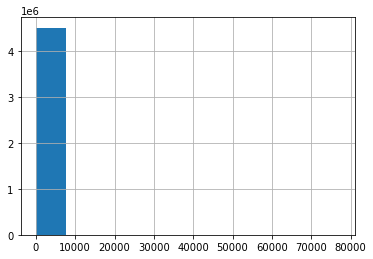

In [23]:
# 看分布与极端值
merge_3['dollar_value'].hist()

<AxesSubplot:>

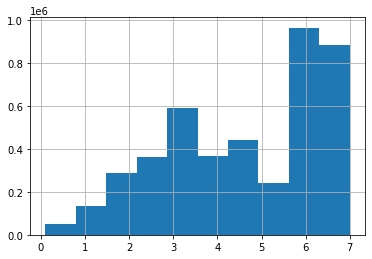

In [24]:
# 看分布与极端值
merge_3['take_rate'].hist()

In [15]:
merge_3['dollar_value'].sort_values()

2090955        0.000007
3251609        0.000025
825805         0.000026
760959         0.000077
1758798        0.000102
               ...     
4355696    50209.505439
1203109    51876.637564
1153407    56552.394443
2788865    67706.740191
3094726    77320.869803
Name: dollar_value, Length: 4508106, dtype: float64

In [26]:
merge_3['take_rate'].unique()

array([6.98, 2.94, 3.92, 6.33, 1.84, 2.42, 6.18, 3.59, 1.57, 4.64, 5.8 ,
       6.61, 4.87, 6.1 , 3.81, 2.68,  nan, 4.7 , 4.41, 2.86, 1.88, 5.05,
       4.31, 4.69, 3.17, 4.46, 6.31, 6.13, 3.5 , 5.97, 5.1 , 4.16, 6.55,
       2.72, 6.77, 1.47, 3.43, 5.52, 3.88, 6.15, 4.93, 6.48, 3.15, 6.7 ,
       3.41, 6.37, 5.56, 6.09, 2.04, 1.52, 5.65, 3.71, 3.49, 6.  , 4.77,
       5.93, 5.71, 6.74, 6.42, 3.05, 6.22, 6.81, 6.43, 6.86, 4.91, 4.95,
       5.53, 6.78, 4.47, 3.3 , 6.35, 5.07, 2.48, 5.68, 5.72, 4.8 , 4.07,
       2.73, 6.01, 5.51, 6.41, 1.94, 2.62, 5.94, 6.39, 6.26, 5.64, 6.38,
       4.81, 0.56, 6.58, 5.76, 2.93, 0.22, 1.04, 3.44, 3.74, 6.99, 5.09,
       6.59, 6.64, 5.77, 1.89, 1.91, 5.99, 6.16, 2.88, 3.72, 2.69, 3.83,
       3.84, 6.72, 6.34, 2.5 , 5.88, 4.08, 1.86, 4.45, 2.03, 5.98, 2.91,
       5.66, 3.36, 6.9 , 4.02, 0.38, 1.78, 3.27, 3.24, 5.9 , 5.95, 3.68,
       5.82, 3.04, 6.24, 6.54, 5.89, 6.69, 3.76, 1.44, 6.6 , 5.03, 6.57,
       3.91, 3.85, 2.06, 6.02, 0.24, 1.13, 4.52, 4.

In [27]:
# 看缺失情况
merge_3.isnull().sum()

user_id                0
merchant_abn           0
dollar_value           0
order_id               0
date                   0
name_x                 0
address                0
state                  0
postcode               0
gender                 0
consumer_id            0
name_y            184414
tags              184414
revenue_levels    184414
take_rate         184414
dtype: int64

In [14]:
# 缺失率
missing_rate = round(184414/4508106,4)
missing_rate

0.0409

KeyboardInterrupt: 

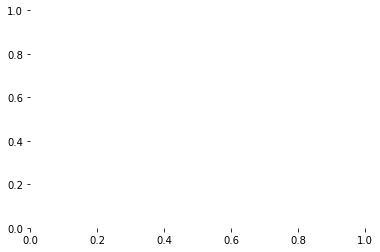

In [17]:
import seaborn
import matplotlib.pyplot as plt
seaborn.heatmap(merge_3.isnull(), yticklabels=False, cbar=False, cmap='viridis')
# 热力图，当data中有空值时标为黄色
plt.tight_layout() 
plt.show()

<AxesSubplot:>

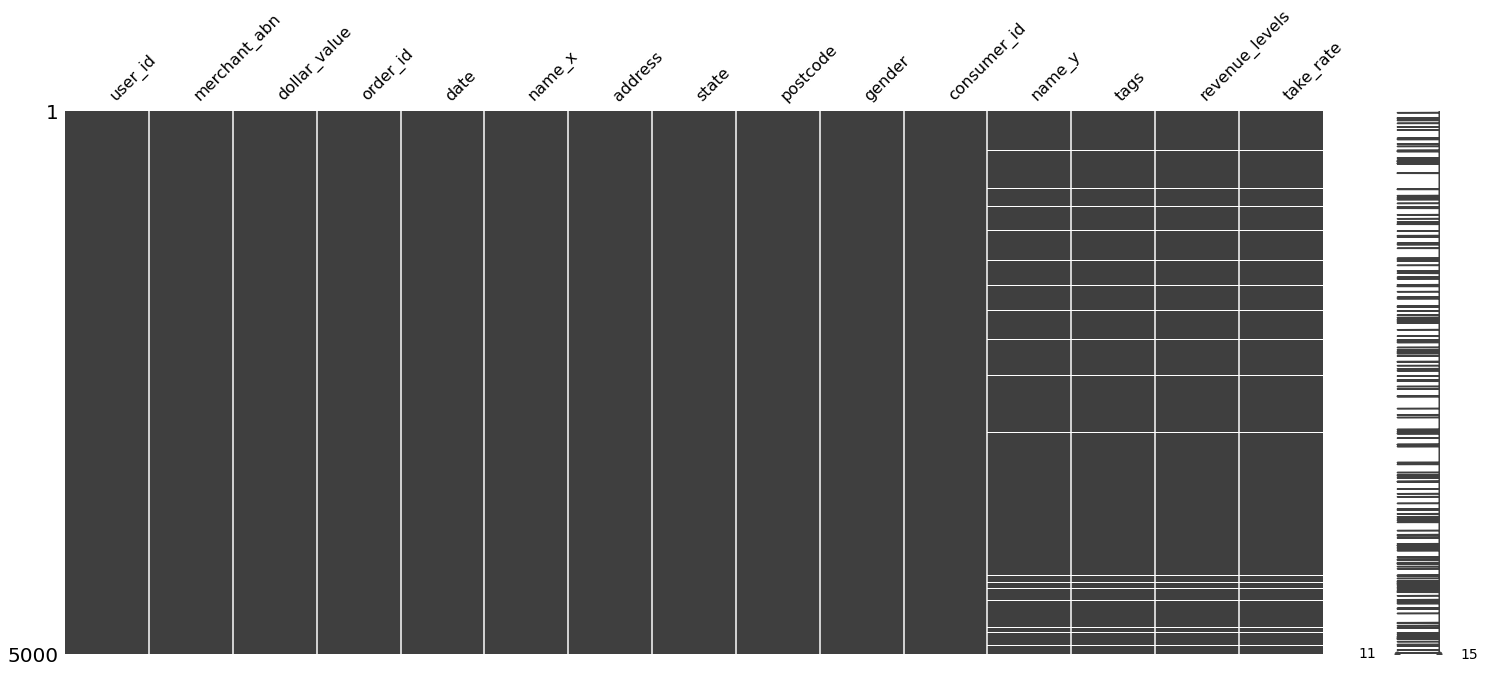

In [ ]:
# !pip install missingno
import missingno as msno

## 绘制缺失值矩阵图
msno.matrix #无效矩阵是一个数据密集的显示，它可以快速直观地看出数据完整度。  
msno.matrix(merge_3.sample(5000))

- 从数据可以看出 merchant_name,tags,revenue_levels和take_rate缺失最严重,这些都是商品表（tbl_merchants）的属性，因此是商品表不全导致匹配不上或者是id出现错误，我们要检查一下。

In [ ]:
# 看异常值
merge_3[merge_3.name_y.isnull()]

,user_id,merchant_abn,dollar_value,order_id,date,name_x,address,state,postcode,gender,consumer_id,name_y,tags,revenue_levels,take_rate
16,14,43820812476,163.617003,62175fef-d6f5-4bcc-a17b-31c617ca40f3,2021-08-28,Lance Butler,8943 Kenneth Camp,VIC,3332,Male,1343547,NaN,NaN,NaN,NaN
27,14949,32234779638,78.340662,9f717f37-da06-4f47-abbf-cad670b3518f,2021-08-28,Charles Mendoza,7257 Deborah Pike Suite 753,VIC,3533,Male,816111,NaN,NaN,NaN,NaN
42,34,29323795999,23.351839,5aadaf04-9f0f-4d4d-96a5-e14dc131871a,2021-08-28,Dakota Kelley,328 Manning Summit Apt. 216,NSW,2823,Male,773039,NaN,NaN,NaN,NaN
107,15000,53997373109,327.125541,578c3c42-21b2-4225-ab1c-cf78ae7bc188,2021-08-28,Jose Adams,7154 Wright Hollow,VIC,3102,Male,691041,NaN,NaN,NaN,NaN
141,15021,57959696529,2008.250733,33498d8b-09ce-4b54-bdc5-25be3977f4b2,2021-08-28,Cynthia Cervantes,72523 Miller Radial Apt. 738,NSW,2029,Female,665368,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4508000,14810,95492562735,214.227392,fb7bae0c-46d1-431a-827f-efff9d37c583,2022-02-27,Dr. Amanda James DVM,37690 Walker Flats,WA,6961,Female,671807,NaN,NaN,NaN,NaN
4508066,14880,67330176930,101.096921,236bfc74-e3ed-4548-924c-cc48154cf80c,2022-02-27,John Fisher,33409 Jones Meadows,VIC,3062,Male,781402,NaN,NaN,NaN,NaN
4508071,14888,91848160033,42.700690,c63c4ea9-7b61-495b-b5b5-a2e81ab47dc4,2022-02-27,Terri Little,2376 Gina Lights Suite 896,VIC,3052,Female,590354,NaN,NaN,NaN,NaN
4508084,14902,32234779638,87.401381,d477c76a-6997-4022-8d34-da9becd9beb2,2022-02-27,Julie Rowe,95947 Flores Run,NSW,1036,Undisclosed,1346423,NaN,NaN,NaN,NaN


In [ ]:
merge_3[merge_3.name_y.isnull()]['merchant_abn'].unique().shape # 缺少了381个商品信息

(381,)

In [ ]:
merge_3['state'].value_counts()

NSW    1301083
VIC    1040906
WA      713271
QLD     667956
SA      512386
TAS     167178
NT       64224
ACT      41102
Name: state, dtype: int64

<BarContainer object of 8 artists>

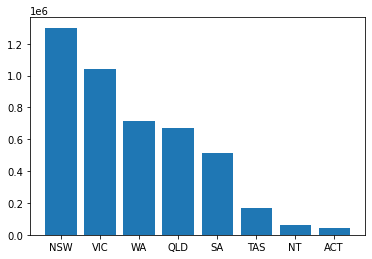

In [ ]:
plt.bar(merge_3['state'].value_counts().index,merge_3['state'].value_counts().values)

In [ ]:
merge_3['dollar_value'].value_counts() ## 成交价格有很多是157元的，其他都是唯一的

157.000000    12723
43.738115         1
16.101388         1
153.134522        1
53.212105         1
              ...  
6.331250          1
3.409148          1
50.486093         1
155.170182        1
196.988323        1
Name: dollar_value, Length: 4495384, dtype: int64

In [15]:
## 删除离群值和空值
import numpy as np
clean = merge_3.copy()
dollar_data = clean.dollar_value
q1 = np.percentile(dollar_data,25)
q3 = np.percentile(dollar_data,75)
iqr = q3-q1
clean= clean[(clean.dollar_value >= q1-iqr) & (clean.dollar_value <= q3+iqr)]

<AxesSubplot:>

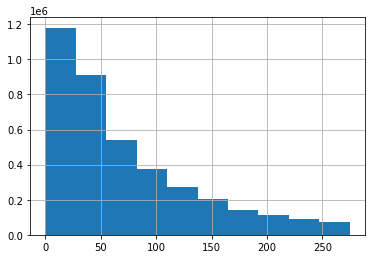

In [ ]:
clean['dollar_value'].hist() 

<AxesSubplot:>

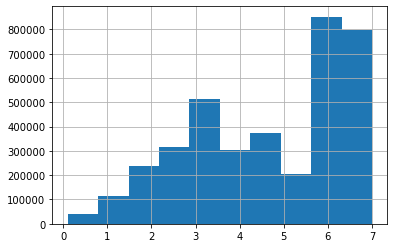

In [ ]:
clean['take_rate'].hist()

In [16]:
take_rate_data = clean.take_rate.dropna()
q1 = np.percentile(take_rate_data,25)
q3 = np.percentile(take_rate_data,75)
iqr = q3-q1
clean = clean[(clean.take_rate >= q1-iqr) & (clean.take_rate <= q3+iqr)]

<AxesSubplot:>

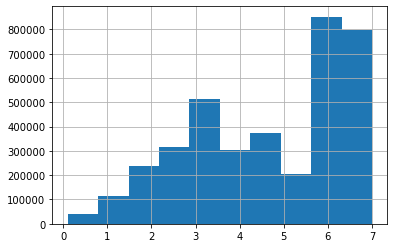

In [ ]:
clean['take_rate'].hist()

In [17]:
clean = clean.dropna().drop_duplicates()

In [19]:
clean.to_parquet("../data/curated/cleaned_merge3_old.parquet")